# Projectile motion in 2D

### Background

Consider a projectile of mass $m$ launchd at an angle $\theta$ to the horizontal from level ground. It reaches the ground some distance $d$ away from the launch site. The equation of motion of the projectile with atmospheric drag (at low enough speeds that no turbulence is created) is: $$ m \frac{d\vec{v}}{dt} = m g \hat{y} -c\vec{v},$$
where $\vec{v}(t) = (v_x(t), v_y(t))$ is the projectile velocity at time $t$. The constant $c$ characterizes the atmosphereic friction. (As an aside, if the motion of the projectile is fast enough that turbulence is created, the friction term changes to $-bv^2$). We will integrate the equation of motion numerically in this project. However, in this case, an analytic solution is possible. If we call $\vec{r}(t) = (x(t), y(t))$ the position of the projectile at time $t$, the equation of motion can be integrated to give:
$$x(t) =\frac{v_0v_T}{g}(1-e^{-gt/v_t}) \cos\theta $$
$$y(t) = \frac{v_T}{g} (v_T + v_0 \sin\theta)(1-e^{-gt/v_t}) - v_T t$$
where $v_T = mg/c$ is the terminal velocity, and $v_0$ is the initial speed.

### Objectives:

* Implement a numerical solution of the equation of motion.
* Compare numerical solution to analytic solution.
* Automatically determine the following characteristics:
    * What is the distance $d$ to impact?
    * What is the maximum height, $h$, reached?
    * What is the time of flight, $T$?
    * What is the velocity, $v_I$ at the impact point?
* Be able to change the initial conditions and still produce a nice plot.

## Implementation

#### Description:
This code uses the odeint function from scipy.integrate to numerically solve the ODE for projectile motion equation with atmospheric friction, given initial parameters.

#### Returns:
1. A 2-dimensional plot of the numerical and analytical solution of the ODE.
2. Distance to impact of projectile (m).
3. Maximum height reached by projectile (m).
4. Time of flight (s).
5. Magnitude of velocity at impact (m/s).
6. Direction of velocity at impact (degrees from horizontal).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

Setting initial parameters
* `c` :  Value that characterizes atmospheric friction (kg/s). $0 \leq c < \infty$
* `g` :  Acceleration due to gravity around the projectile's location (m/s^2). $0 \leq g < \infty$
* `m` :  Mass of projectile (kg). $0 \leq m < \infty$
* `v0` :  Magnitude of the initial velocity (m/s). $0 \leq v < \infty$
* `thetad` : Direction of initial velocity above horizontal axis (degrees). $0 \leq \theta_d < 360$


In [2]:
c = 0.65
g = 9.81
m = 0.1
v0 = 10
thetad = 1

Converting initial values into a usable form, most notably, converting the initial angle and speed into a velocity vector.

In [3]:
thetar = np.radians(thetad)
v0x, v0y = (v0 * np.cos(thetar), v0 * np.sin(thetar))  # Initial velocities
x0, y0 = (0, 0)  # Initial position of projectile
init_vals = np.array([v0x, v0y, x0, y0])
constants = (c, g, m)

t0 = 0.0
steps = 2000

Defining a helper function to calculate the derivative of the velocity. This will be used to provide the input for the odeint() function.

Parameters:
* `init_vals` : list or numpy array containing initial conditions in form [v0x, v0y, x0, y0]
* `time` : odeint expects the function to be integrated to have a time component, even when it is not used
* `c`, `g`, `m` : constants used in calculations.  See script header for more information.

In [4]:
def dvdt(init_vals, time, c, g, m):
    v0x, v0y = init_vals[0], init_vals[1]
    dvxdt = -c * v0x / m
    dvydt = -g - c * v0y / m
    return np.array([dvxdt, dvydt, v0x, v0y])

This next section caluclates a reasonable upper bound for the timeframe to integrate over by solving $y = y_0 + \dot{y}_0 t + \frac{1}{2} \ddot{y} t^2$ for $y = 0$ and $\ddot{y} = -g$ using the quadratic formula

In [5]:
if g > 0:
    root = np.sqrt(v0y**2 - 2*(-g)*np.abs(y0))
    t1 = (-v0y + root) / (-g)
    t2 = (-v0y - root) / (-g)
    tmax = max([t1, t2])
else:
    tmax = np.log(c/m)  # Found by trial and error

Setting up the timeframe to integrate over and performing the integration of the ODE. The last few lines are decomposing the numerical solution into their individual components.

In [6]:
timeframe = np.linspace(t0, tmax, steps + 1)

num_sol = integrate.odeint(dvdt, init_vals, timeframe, args=constants)

vx = num_sol[:, 0]
vy = num_sol[:, 1]
x = num_sol[:, 2]
y = num_sol[:, 3]

Setting up a function to compute the position of the particle using the analytical solution of the ODE. It is important to note that this function can also handle the edge cases where $g$ or $c$ are $0$, which is not true of the given analytic solution.

#### Parameters:
* `x0`, `y0` : Initial x and y coordinate of particle.
* `v0`, `thetar` : Magnitude of initial velocity of particle and its direction in radians above horizontal.
* `t` : Time.  Use a single value to compute the location of the particle at that time or use np.ndarray to return an array of x and y coordinates for the time values stored in the array.
* `c`, `g`, `m` : Constants used in calculations.  See script header for more information.

In [7]:
def analytic_sol(x0, y0, v0, thetar, t, c, g, m):
    if c != 0 and g != 0:
        vT = m * g/c
        xpos = x0 + v0*vT/g * (1-np.exp(-g*t/vT))*np.cos(thetar)
        ypos = y0 + vT/g * (vT + v0*np.sin(thetar)) * \
            (1 - np.exp(-g*t/vT)) - vT*t
    elif c == 0 and g != 0:
        xpos = x0 + v0*np.cos(thetar)*t
        ypos = y0 + v0*np.sin(thetar)*t - 0.5*g*t**2
    elif c != 0 and g == 0:
        xpos = x0 + v0*m/c * (1 - np.exp(-c*t/m)) * np.cos(thetar)
        ypos = y0 + m/c * (v0*np.sin(thetar)) * (1 - np.exp(-c*t/m))
    elif c == 0 and g == 0:
        xpos = x0 + v0*np.cos(thetar)*t
        ypos = y0 + v0*np.sin(thetar)*t
    return np.array([xpos]), np.array([ypos])

Computing the analytical solution.

In [8]:
ax, ay = analytic_sol(x0, y0, v0, thetar, timeframe, *constants)

Defining some filters for the analytical and numerical solutions. Also computing the number of steps between samples of the numerical solution to display roughly 20 evenly spaced points of the numerical solution.

In [9]:
ayabove0 = (ay >= 0)
nyabove0 = (y >= 0)

stepsize = int(len(x[nyabove0])/20)  # Step size needed to display ~20 points

Plotting the numerical and analytical solutions.

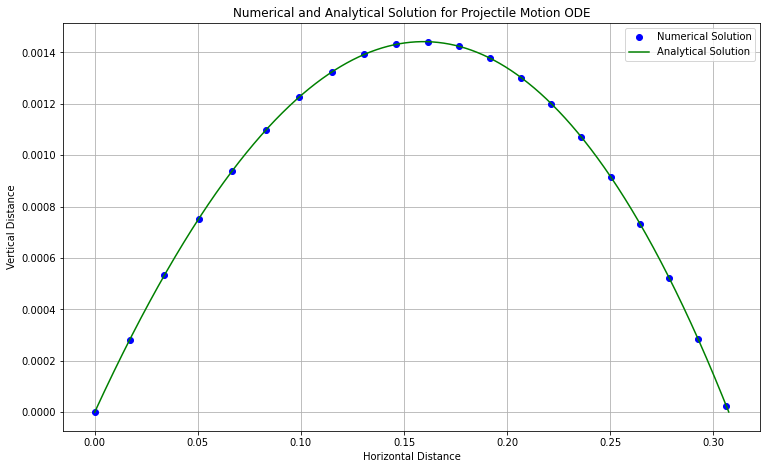

In [10]:
plt.figure(figsize=(12.5, 7.5))
plt.title('Numerical and Analytical Solution for Projectile Motion ODE')
plt.xlabel('Horizontal Distance')
plt.ylabel('Vertical Distance')
plt.plot(x[nyabove0][::stepsize], y[nyabove0][::stepsize],
         'bo', label='Numerical Solution')
plt.plot(ax[ayabove0], ay[ayabove0], 'g', label='Analytical Solution')
plt.legend()
plt.grid()
plt.show()

Extracting and computing the characteristics of the moton mentioned above.

In [11]:
ytrimmed = y[nyabove0][1:]  # removes the first entry (y[1] is 0)
yimpactindex = np.argmin(ytrimmed)
yimpact = y[yimpactindex]
ximpact = x[1:][yimpactindex]  # does not read first entry to avoid issues
ximpactdist = np.abs(ximpact - x0)
yimpactdist = np.abs(yimpact - y0)
impactdist = np.sqrt(ximpactdist**2 + yimpactdist**2)
print(f'Distance to impact is: {impactdist.round(decimals=3)} m')

maxheight = np.abs(y0 - np.amax(y))
print(f'The maximum height reached is: {maxheight.round(decimals=3)} m')

Tof = timeframe[1:][yimpactindex]
print(f'The time of flight is: {Tof.round(decimals=3)} s')

vxI = vx[1:][yimpactindex]
vyI = vy[1:][yimpactindex]
vI = np.sqrt(vxI**2 + vyI**2)
vIthetar = np.arctan(vyI / vxI)
vIthetad = np.rad2deg(vIthetar)
print(f'The velocity at impact is: {vI.round(decimals=3)} m/s \
{vIthetad.round(decimals=3)} degrees from the horizontal')

Distance to impact is: 0.307 m
The maximum height reached is: 0.001 m
The time of flight is: 0.034 s
The velocity at impact is: 8.002 m/s -1.16 degrees from the horizontal
